In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import pdb

Define model


In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available

class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 6, 4)
      self.pool1 = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 4)
      # pool
      self.fc1 = nn.Linear(16 * 5 * 5, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

      #batch_norm
      self.batch_norm1 = nn.BatchNorm2d(6)
      self.batch_norm2 = nn.BatchNorm2d(16)

    def forward(self, x):
      # (batch_size, 3, 32, 32)
      # import ipdb; ipdb.set_trace()
      x = self.conv1(x) # => (b, 6, 28, 28)
      x = self.batch_norm1(x)
      x = F.leaky_relu(x)
      x = self.pool1(x) # => (b, 6, 14, 14)

      x = self.pool1(F.leaky_relu(self.batch_norm2(self.conv2(x)))) # => (b, 16, 10, 10) => (b, 16, 5, 5)

      x = x.view(-1, 16 * 5 * 5) # => [b, 16 * 5 * 5]

      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))

      x = self.fc3(x)
      
      return x

    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    @torch.no_grad()
    def validation_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    @torch.no_grad()
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, train_loss, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, train_loss, result['val_loss'], result['val_acc']))

net = Net()
net = net.to(device)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available

class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv_layer = nn.Sequential(

          # Conv Layer block 1
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          # Conv Layer block 2
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=0.05),

          # Conv Layer block 3
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )


      self.fc_layer = nn.Sequential(
          nn.Dropout(p=0.1),
          nn.Linear(4096, 1024),
          nn.ReLU(inplace=True),
          nn.Linear(1024, 512),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.1),
          nn.Linear(512, 10)
      )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x
      

    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    @torch.no_grad()
    def validation_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    @torch.no_grad()
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, train_loss, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, train_loss, result['val_loss'], result['val_acc']))

net = Net()
net = net.to(device)

Define sets with augmented data

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5),
                                              inplace=True)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

val_size = 10000
train_size = len(trainset) - val_size

trainset, validationset = random_split(trainset, [train_size, val_size])
len(trainset), len(validationset)

Files already downloaded and verified
Files already downloaded and verified


(40000, 10000)

Define data loaders

In [10]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size,
                                        shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(validationset, batch_size, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size,
                                        shuffle=False, num_workers=2)

torch.Size([64, 3, 32, 32])



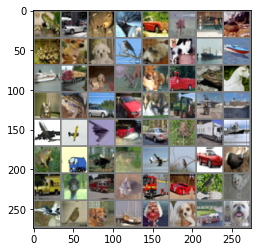

 frog   car  frog  deer


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

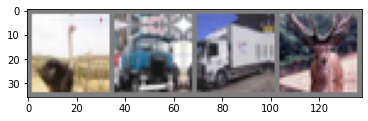

GroundTruth:   bird truck truck  deer


In [12]:
# Check the ground truth images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define training loop function

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def train(num_epochs, train_loader, val_loader, net, criterion, optimizer):
    history = []
    train_it = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            # forward
            loss = net.training_step(data)

            # backward
            loss.backward()

            # update the weights
            optimizer.step() # 1 step over optimizer

            running_loss += loss.item()

            train_it += 1

        # Validation phase
        running_loss /= len(train_loader)
        result = evaluate(net, val_loader)
        net.epoch_end(running_loss, epoch, result)
        result['train_loss'] = running_loss
        history.append(result)

    return history

Define loss function and optimizer.
Run train loop and save model


In [14]:
def plot_losses(history):
    plt.subplot(2, 1, 1)
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-o')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.gcf().set_size_inches(15, 12)

In [15]:
def plot_accuracies(history):
    plt.subplot(2, 1, 2)
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.gcf().set_size_inches(15, 12)

Epoch [0], train_loss: 1.6764, val_loss: 1.3976, val_acc: 0.4755
Epoch [1], train_loss: 1.2933, val_loss: 1.1780, val_acc: 0.5775
Epoch [2], train_loss: 1.1287, val_loss: 1.0484, val_acc: 0.6246
Epoch [3], train_loss: 1.0226, val_loss: 1.0036, val_acc: 0.6450
Epoch [4], train_loss: 0.9406, val_loss: 0.8996, val_acc: 0.6835
Epoch [5], train_loss: 0.8790, val_loss: 0.8807, val_acc: 0.6936
Epoch [6], train_loss: 0.8361, val_loss: 0.8140, val_acc: 0.7134
Epoch [7], train_loss: 0.7906, val_loss: 0.8205, val_acc: 0.7237
Epoch [8], train_loss: 0.7587, val_loss: 0.7507, val_acc: 0.7377
Epoch [9], train_loss: 0.7215, val_loss: 0.7441, val_acc: 0.7389
Epoch [10], train_loss: 0.6978, val_loss: 0.7449, val_acc: 0.7451
Epoch [11], train_loss: 0.6702, val_loss: 0.7387, val_acc: 0.7478
Epoch [12], train_loss: 0.6487, val_loss: 0.6753, val_acc: 0.7714
Epoch [13], train_loss: 0.6320, val_loss: 0.6648, val_acc: 0.7722
Epoch [14], train_loss: 0.6117, val_loss: 0.6626, val_acc: 0.7763


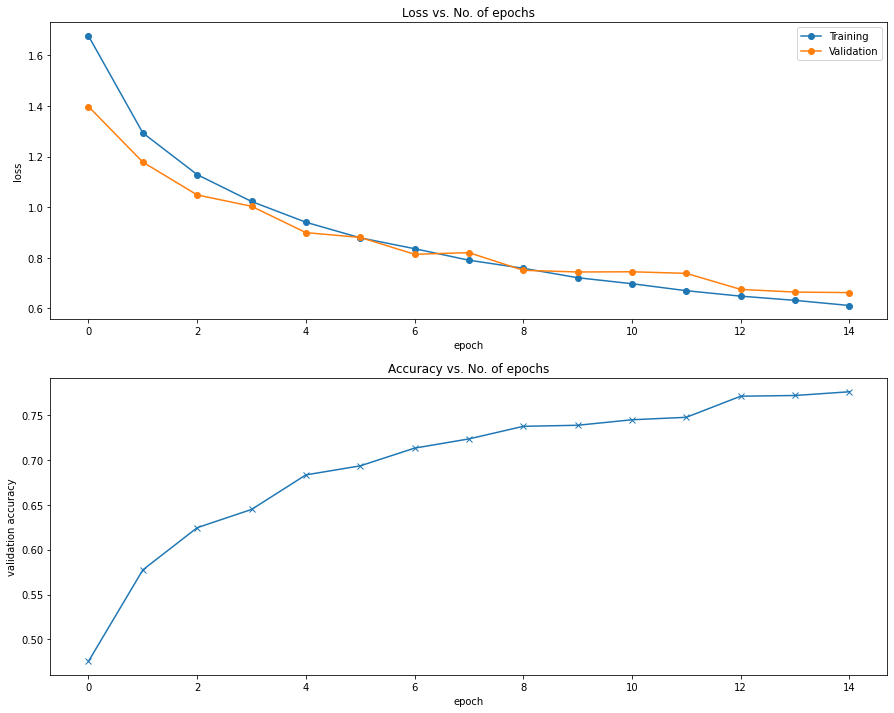

In [16]:
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

history = train(num_epochs, trainloader, valloader, net, criterion, optimizer)

plot_losses(history)
plot_accuracies(history)

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

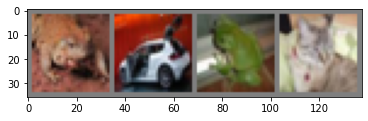

GroundTruth:   frog   car  frog   cat


In [18]:
# Check the ground truth images
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[5:9]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5,9)))

Load saved model

In [19]:
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.to(device)

Load model and get accuracy with testloader

In [20]:
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
print(outputs)
print(outputs.shape)

max_val, predicted = torch.max(outputs, 1)    # torch.max returns the maximum value as well as the index
# second argument stands for the dimension I want to compute the max value of
print(max_val, predicted)

# Print the predicted classes
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                            for j in range(4)))

                            # Loop over the test set and compute accuracy
correct = 0
total = 0

tensor([[-3.2102e+00, -5.2227e+00, -2.5554e+00,  4.3600e+00, -4.1020e+00,
          4.0815e-01, -1.4292e-01, -3.7360e+00, -1.8791e+00, -3.5601e+00],
        [ 5.1434e-01,  1.0787e+00, -4.5209e+00, -5.1658e+00, -5.4518e+00,
         -9.5796e+00, -3.5617e+00, -9.8015e+00,  7.8204e+00, -2.5541e+00],
        [ 3.6024e-01,  5.9465e-01, -3.7803e+00, -3.9447e+00, -5.3626e+00,
         -7.2837e+00, -3.9345e+00, -7.7248e+00,  6.3889e+00, -9.7095e-01],
        [ 1.5034e+00, -1.2828e+00, -1.9502e+00, -2.9651e+00, -3.1946e+00,
         -7.1057e+00, -2.6118e+00, -7.5506e+00,  5.5784e+00, -2.2322e+00],
        [-8.6582e+00, -2.6773e+00, -2.0507e+00, -3.1939e+00, -3.2224e+00,
         -4.9053e+00,  7.5056e+00, -8.8231e+00, -6.3056e+00, -4.1296e+00],
        [-8.4450e+00, -4.6926e+00, -1.0458e+00,  7.1197e-01, -1.2303e+00,
         -3.3925e+00,  7.8110e+00, -8.8249e+00, -1.0732e+01, -5.1554e+00],
        [-3.6090e+00,  4.9342e+00, -5.9526e+00, -3.0387e+00, -1.0719e+01,
         -3.2723e+00, -2.3373e+0

Compute accuracy on test set

In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 88 %
Accuracy of  bird : 65 %
Accuracy of   cat : 58 %
Accuracy of  deer : 65 %
Accuracy of   dog : 67 %
Accuracy of  frog : 85 %
Accuracy of horse : 71 %
Accuracy of  ship : 94 %
Accuracy of truck : 89 %


In [22]:
# Loop over the test set and compute accuracy
correct = 0
total = 0

# I don't want to compute grad during my test time
all_labels = []
all_preds = []
confusion_matrix_data = np.zeros([10,10], int)
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)

    sm = nn.Softmax(dim=1)
    outputs = net(images)
    sm_outputs = sm(outputs)

    max_val, predicted = torch.max(outputs, 1)
    for i, l in enumerate(labels):
        all_labels.append(l.item())
        all_preds.append(predicted[i].item())
        confusion_matrix_data[l.item(), predicted[i].item()] += 1 
    # all_labels.append(labels.cpu().numpy(), axis=0)
    # all_pred.append(predicted.cpu().numpy(), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item() # item gives you the numerical value of that

print('Accuracy: ', 100 * correct / total)

Accuracy:  78.54


In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=all_labels, 
                         y_pred=all_preds)

for i in range(len(classes)):
    class_name = "({}) {}".format(i, classes[i])
    print(cm[i, :], class_name)
    
    # Print the class-numbers for easy reference
    class_numbers = [" ({0})".format(i) for i in range(len(classes))]
    # print("".join(class_numbers))

[746  19  53  12  13   0   5   8 109  35] (0) plane
[  9 871   2   1   1   1   5   1  32  77] (1) car
[ 46   2 677  43  52  57  76  25  17   5] (2) bird
[ 10   6  56 615  44 135  67  28  15  24] (3) cat
[ 10   0  56  55 733  14  61  61   5   5] (4) deer
[  7   2  41 132  34 726  12  36   5   5] (5) dog
[  6   1  52  41   7  10 867   1  11   4] (6) frog
[ 14   2  27  30  59  60   5 784   7  12] (7) horse
[ 16  16  12   5   4   3   7   4 922  11] (8) ship
[ 14  25   1   3   1   2   3   2  36 913] (9) truck


Category   - Accuracy
plane      - 74.6
car        - 87.1
bird       - 67.7
cat        - 61.5
deer       - 73.3
dog        - 72.6
frog       - 86.7
horse      - 78.4
ship       - 92.2
truck      - 91.3


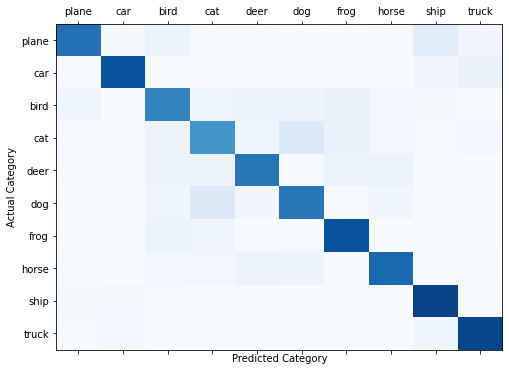

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           746       19        53        12        13        0         5         8         109       35        
                0.746     0.019     0.053     0.012     0.013     0.0       0.005     0.008     0.109     0.035     
car             9         871       2         1         1         1         5         1         32        77        
                0.009     0.871     0.002     0.001     0.001     0.001     0.005     0.001     0.032     0.077     
bird            46        2         677       43        52        57        76        25        17        5         
                0.046     0.002     0.677     0.043     0.052     0.057     0.076     0.025     0.017     0.005     
cat             10        6         56        615       44        135       67        28        15        24        
                0.01      0.006     0.056     0.615     0.044   

In [24]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix_data):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix_data, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix_data):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
